In [1]:
#Importing necessary libraries:
import numpy as np
import math
import matplotlib.pyplot as plt
import glob
import os
from math import sqrt
import cv2 as cv
from collections import Counter
from statistics import mean
np.random.seed(0)

In [2]:
#Assigning the path to training images:
path=r'C:\Users\Arqam Nisar\Training set'
Dogs = glob.glob(os.path.join(path , 'Dogs'+'//*.*'))
Lions = glob.glob(os.path.join(path , 'Lions'+'//*.*'))

#Making a matrix of Data with Dogs and Lions Images:
Data=[Dogs,Lions]

#A function for reading the labels and assigning the data to a variable as well.
#Converting the images to Grayscale as well
def Reading_labeling(Data):
    data = []
    labels = []
    count=0
    for i in Data:
        count = count+1
        for j in i:
            image = cv.imread(j, cv.IMREAD_GRAYSCALE)
            new_image = cv.resize(image, (32,32))
            data.append(new_image)
            if count == 1:
                labels.append(0)
            elif count == 2:
                labels.append(1)
    return data, labels


#Declaring variables for data and labels:
data, labels = Reading_labeling(Data)

In [3]:
#Converting the data to a list so that we can use it as a dictionary:
data = np.array(data)
data  = data / 255

#shuffle function for random data:
from random import shuffle
shuffle(data)
shuffle(labels)

labels = np.array(labels)
labels

#Splitting the data into training and testing data:
training_data = data[0:12]
cross_validation_data = data[12:16]
testing_data = data[16:20]

X_train = np.reshape(training_data, (12,1024))
X_cv = np.reshape(cross_validation_data, (4,1024))
X_test = np.reshape(testing_data, (4,1024))


Y_train = labels[0:12]
Y_cv = labels[12:16]
Y_test = labels[16:20]

In [4]:
#Activation Functions:
#Sigmoid:
def sigmoid(x):
    return (1/(1 + np.exp(-x)))

def der_sigmoid(x):
    return (x * (1 - x))

def ReLU(x):
    return max(0, x)

def der_ReLU(x):
    return x > 0

def tanh(x):
    a = (2 / (1 + np.exp(-2*x))) - 1
    return a

def der_tanh(x):
    return 1 - x**2

def one_hot(Y):
    one_hot_y = np.zeros((Y.size, Y.max() + 1))
    one_hot_y[np.arange(Y.size), Y] = 1
    one_hot_y = one_hot_y.T
    return one_hot_y

In [5]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = np.random.randn(n_inputs, n_neurons)
        self.biases = np.random.randn(1, n_neurons)
    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases
        
class Activation_ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)

class Activation_tanh:
    def forward(self, inputs):
        self.output = (2 / (1 + np.exp(-2 * inputs))) - 1

class Activation_Sigmoid:
    def forward(self, inputs):
        self.output = (1 / (1 + np.exp(-inputs)))

class Activation_Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.sum(inputs, axis = 1, keepdims = True))
        probs = exp_values / np.sum(exp_values, axis = 1, keepdims = True)
        self.output = probs
    
class Loss:
    def calculate(self, output, y):
        losses = self.forward(output, y)
        data_loss = np.mean(losses)
        return data_loss
    
class Loss_crossEntropy(Loss):
    def forward(self, y_hat, y_org):
        n_samples = len(y_hat)
        y_hat_clip = np.clip(y_hat, 1e-7, 1-1e-7)
        
        if len(y_org.shape) == 1:
            correct_confidences = y_hat_clip[range(n_samples), y_org]
        elif len(y_org.shape) == 2:
            correct_confidences = np.sum(y_hat_clip * y_org, axis = 1)
            
        negative_log = -np.log(correct_confidences)
        return negative_log

lr = 0.00006
epoch = 100
l = []
acc = []

#Forward Propagation(Input layer to first Hidden Layer):    
dense1 = Layer_Dense(32 * 32,10)
activation1 = Activation_ReLU()

#Forward Propagation(First Hidden layer to Second Hidden Layer):
dense2 = Layer_Dense(10,10)
activation2 = Activation_ReLU()

#Forward Propagation(Second Hidden Layer to Third Hidden Layer):
dense3 = Layer_Dense(10,10)
activation3 = Activation_ReLU()

#Forward Propagation(Third Hidden Layer to Output Layer):
dense4 = Layer_Dense(10,2)
activation4 = Activation_Sigmoid()

def Training(X, Y):
    
    for i in range(epoch):
    
        
        #Activation functions applied on each layer:
        dense1.forward(X_train)
        activation1.forward(dense1.output)

        dense2.forward(activation1.output)
        activation2.forward(dense2.output)

        dense3.forward(activation2.output)
        activation3.forward(dense3.output)

        dense4.forward(activation3.output)
        activation4.forward(dense4.output)

        softmax_outputs = np.array(activation4.output)
        predictions = np.argmax(activation4.output, axis = 1)
        accuracy = np.mean(predictions == Y_train)
        acc.append(accuracy)
        #Weights update:
        dz4 = activation4.output.T - one_hot(Y_train)
        dW4 = dz4.dot(activation3.output)
        db4 = np.sum(dz4, 0)

        W4 = dense4.weights
        W4 = W4 - (lr * dW4.T)
        dense4.weights = W4

        dz3 = W4.dot(dz4)
        dz3 = dz3.T * ((der_ReLU(activation3.output)))
        dW3 = dz3.T.dot(activation2.output)
        db3 = np.sum(dz3, 0)

        W3 = dense3.weights
        W3 = W3 - (lr * dW3)
        dense3.weights = W3

        dz2 = W3.dot(dz3.T)
        dz2 = dz2 * ((der_ReLU(activation2.output).T))
        dW2 = dz2.dot(activation1.output)
        db2 = np.sum(dz2, 0)

        W2 = dense2.weights
        W2 = W2 - (lr * dW2)
        dense2.weights = W2

        dz1 = W2.dot(dz2)
        dz1 = dz1 * ((der_ReLU(activation1.output.T)))
        dW1 = dz1.dot(X_train)
        db1 = np.sum(dz1, 0)

        W1 = dense1.weights
        W1 = W1.T - (lr * dW1)
        dense1.weights = W1.T

        #Loss Function:
        loss_fn = Loss_crossEntropy()
        loss = loss_fn.calculate(activation4.output, Y_train)
        l.append(loss)

        print("Actual Labels", Y_train)
        print("Predicted Ls", predictions)
        print("Training loss: ", loss, "Training accuracy: ", accuracy)

In [6]:
#Training of Neural Network with X_train and Y_train:
Training(X_train, Y_train)

Actual Labels [0 1 1 0 1 1 0 1 1 0 1 0]
Predicted Ls [0 0 0 0 0 0 0 0 0 0 0 0]
Training loss:  9.40222250472569 Training accuracy:  0.4166666666666667
Actual Labels [0 1 1 0 1 1 0 1 1 0 1 0]
Predicted Ls [0 0 0 0 0 0 0 0 0 0 0 0]
Training loss:  9.40222250472569 Training accuracy:  0.4166666666666667
Actual Labels [0 1 1 0 1 1 0 1 1 0 1 0]
Predicted Ls [0 0 0 0 0 0 0 0 0 0 0 0]
Training loss:  9.402487171054128 Training accuracy:  0.4166666666666667
Actual Labels [0 1 1 0 1 1 0 1 1 0 1 0]
Predicted Ls [0 0 0 0 0 0 0 0 0 0 0 0]
Training loss:  9.422078820110135 Training accuracy:  0.4166666666666667
Actual Labels [0 1 1 0 1 1 0 1 1 0 1 0]
Predicted Ls [0 0 0 0 0 0 0 0 0 0 0 0]
Training loss:  9.746711359818908 Training accuracy:  0.4166666666666667
Actual Labels [0 1 1 0 1 1 0 1 1 0 1 0]
Predicted Ls [0 0 0 0 0 0 0 0 0 0 0 0]
Training loss:  9.964858111632685 Training accuracy:  0.4166666666666667
Actual Labels [0 1 1 0 1 1 0 1 1 0 1 0]
Predicted Ls [0 0 0 0 0 0 0 0 0 0 0 0]
Training lo

In [7]:
def Testing(Img, Img_label):
    #Activation functions applied on each layer:
        dense1.forward(Img)
        activation1.forward(dense1.output)

        dense2.forward(activation1.output)
        activation2.forward(dense2.output)

        dense3.forward(activation2.output)
        activation3.forward(dense3.output)

        dense4.forward(activation3.output)
        activation4.forward(dense4.output)
        
        softmax_outputs = np.array(activation4.output)
        predictions = np.argmax(activation4.output, axis = 1)
        accuracy = np.mean(predictions == Img_label)
        
        loss_fn = Loss_crossEntropy()
        loss = loss_fn.calculate(activation4.output, Img_label)
        
        print("Actual Labels", Img_label)
        print("Predicted Ls", predictions)
        print("Loss: ", loss, "Accuracy: ", accuracy)

In [8]:
#Testing with test dataset (X_test):
Testing(X_test, Y_test)

Actual Labels [1 1 0 0]
Predicted Ls [1 0 1 0]
Loss:  2.0229069432291813 Accuracy:  0.5


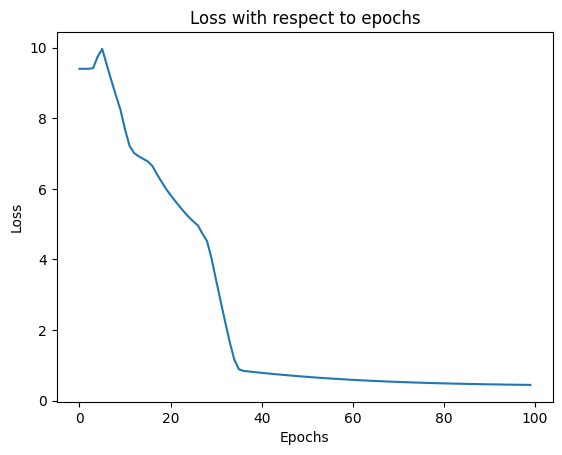

In [9]:
plt.title("Loss with respect to epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(0, len(l)), l[:])

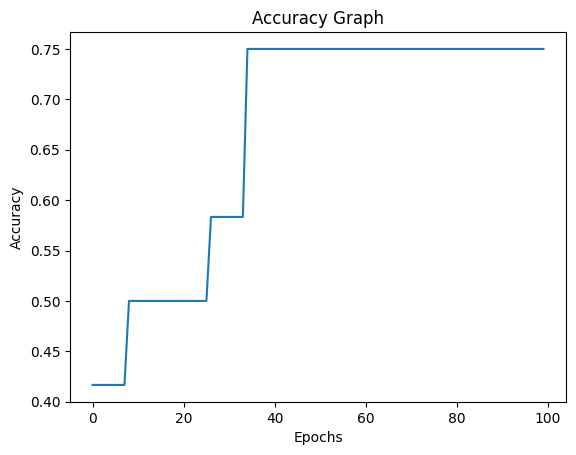

In [10]:
plt.title("Accuracy Graph")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(0, len(l)), acc[:])